In [34]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import *
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential

In [16]:
#Import the data
print(os.listdir("EnergyData/"))

['AEP_hourly.csv', 'AEP_hourly.csv.zip', 'COMED_hourly.csv.zip', 'DAYTON_hourly.csv.zip', 'DEOK_hourly.csv.zip', 'DOM_hourly.csv', 'DOM_hourly.csv.zip', 'DUQ_hourly.csv.zip', 'EKPC_hourly.csv.zip', 'est_hourly.paruqet.zip', 'FE_hourly.csv', 'FE_hourly.csv.zip', 'NI_hourly.csv.zip', 'PJME_hourly.csv.zip', 'PJMW_hourly.csv.zip', 'pjm_hourly_est.csv.zip', 'PJM_Load_hourly.csv']


In [21]:
fpath = 'EnergyData/DOM_hourly.csv/DOM_hourly.csv' #choose path

#create dataframe df using csv from fpath
df = pd.read_csv(fpath)

In [23]:
# Check the header
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [24]:
#Let's change how we are viewing this data in numbering. We actually don't need the first column. Insead, let's use Datetime. 
#When dealing iwht timeseries data, this is always a good idea
df = pd.read_csv(fpath, index_col = 'Datetime', parse_dates = ['Datetime'])

In [26]:
#Again, check headers to see the change
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [28]:
#Let's do a little data exploring. First, check to see if any data is missing.
df.isna().sum()
#Notice tehre are no missing values

DOM_MW    0
dtype: int64

Text(0.5, 1.0, 'DOM hourly power consumption data - BEFORE NORMALIZATION')

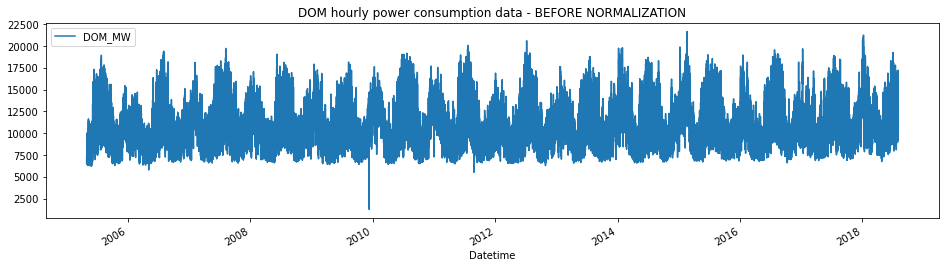

In [30]:
#Next, let's do a visual exploration
df.plot(figsize = (16,4), legend = True)
plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

In [44]:
#Notice that we have large values. Let's normalize our data to be between 0 and 1 (not negative since that doesn't make sense)

#Let's create a definition tha twill normalize this dataset. We will call on this later. 
def normalize_data(df):
    normalization_constant = sklearn.preprocessing.MinMaxScaler() #create the normalization constant based on MinMaxScalar
    df['DOM_MW'] = normalization_constant.fit_transform(df['DOM_MW']. values.reshape(-1,1)) #Scale output column (obviously, since it is the quantitative value)
    return df

df_norm = normalize_data(df)

Text(0.5, 1.0, 'DOM hourly power consumption data - BEFORE NORMALIZATION')

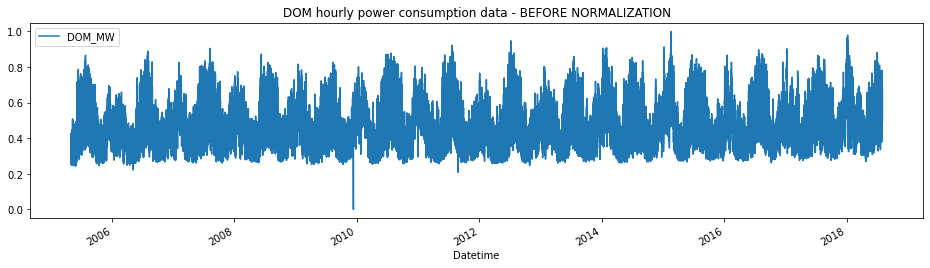

In [46]:
#Let's explore the data again, but using df_norm now (normalized df)
df_norm.plot(figsize = (16,4), legend = True)
plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

In [50]:
#Let's prepare the data for training the Recurrent Neural Network (RNN) model

#Create a function called load_data that will prepare the data
def load_data(data_frame_input,seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(data_frame_input)):
        X_train.append(data_frame_input.iloc[i-seq_len:i,0])
        y_train.append(data_frame_input.iloc[i,0])
    
    #Test on the last 6189 days
    X_test = X_train[110000:]
    y_test = y_train[110000:]
    
    #Train on the first 110000 days
    X_train = X_train[:110000]
    y_train = y_train[:110000]
    
    #Convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test) 
    
    #We need to reshape our data so they are compatible with RNN models, this will be based off the seq_len
    X_train = np.reshape(X_train, (110000, seq_len,1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len,1))
    
    #return the data
    return [X_train,y_train, X_test, y_test]

In [51]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [53]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [57]:
# We are now ready for our SIMPLE RNN Model - this is the sequential approach

#We'll use the hyperbolic tangent function - though we can also use the sigmoid function since we don't have negative values

rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [58]:
#Compile the model use the loss function MSE and optimizer adam
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 6s 39ms/step - loss: 0.1001
Epoch 2/10
110/110 [==============================] - 4s 36ms/step - loss: 0.0202
Epoch 3/10
110/110 [==============================] - 4s 35ms/step - loss: 0.0110
Epoch 4/10
110/110 [==============================] - 4s 34ms/step - loss: 0.0073
Epoch 5/10
110/110 [==============================] - 4s 35ms/step - loss: 0.0053
Epoch 6/10
110/110 [==============================] - 4s 35ms/step - loss: 0.0042
Epoch 7/10
110/110 [==============================] - 4s 35ms/step - loss: 0.0035
Epoch 8/10
110/110 [==============================] - 4s 34ms/step - loss: 0.0030
Epoch 9/10
110/110 [==============================] - 4s 34ms/step - loss: 0.0027
Epoch 10/10
110/110 [==============================] - 4s 34ms/step - loss: 0.0024


In [60]:
#Check r2 scores for the values we just predicted in our SRNN Model
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN Model = ", rnn_score)

193/193 [==============================] - 1s 2ms/step
R2 Score of RNN Model =  0.9497165096285969


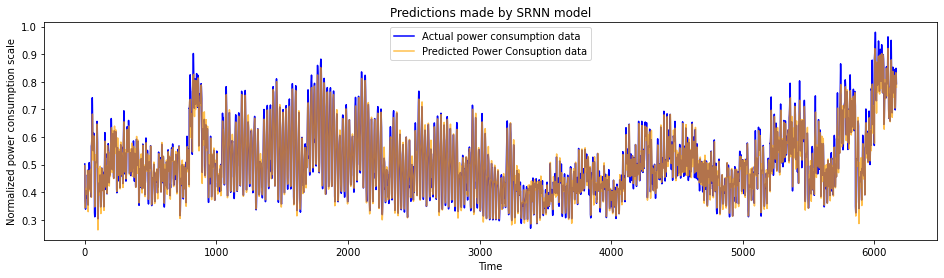

In [61]:
#Now let's compare the actual values with predicted values by plotting

#Create a simple plotting function to visually compare the model

def plot_predictions(test, predicted, title):
    plt.figure(figsize = (16,4))
    plt.plot(test, color='blue', label ='Actual power consumption data')
    plt.plot(predicted, alpha = 0.7, color = 'orange', label = 'Predicted Power Consuption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by SRNN model")

In [62]:
# Next, let's build an LSTM model

#Same sequential architecture 

lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_6 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_7 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [63]:
lstm_model.compile(optimizer = "adam", loss = "MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size = 100)


Epoch 1/10
1100/1100 [==============================] - 19s 14ms/step - loss: 0.0069
Epoch 2/10
1100/1100 [==============================] - 16s 15ms/step - loss: 0.0016
Epoch 3/10
1100/1100 [==============================] - 16s 14ms/step - loss: 9.9594e-04
Epoch 4/10
1100/1100 [==============================] - 16s 15ms/step - loss: 7.4004e-04
Epoch 5/10
1100/1100 [==============================] - 17s 15ms/step - loss: 5.9799e-04
Epoch 6/10
1100/1100 [==============================] - 17s 15ms/step - loss: 5.5225e-04
Epoch 7/10
1100/1100 [==============================] - 17s 15ms/step - loss: 5.1908e-04
Epoch 8/10
1100/1100 [==============================] - 17s 15ms/step - loss: 4.9962e-04
Epoch 9/10
1100/1100 [==============================] - 17s 15ms/step - loss: 4.7783e-04
Epoch 10/10
1100/1100 [==============================] - 17s 16ms/step - loss: 4.5527e-04


In [64]:
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R2 Score of LSTM model =", lstm_score)

193/193 [==============================] - 2s 5ms/step
R2 Score of LSTM model = 0.966507979115304


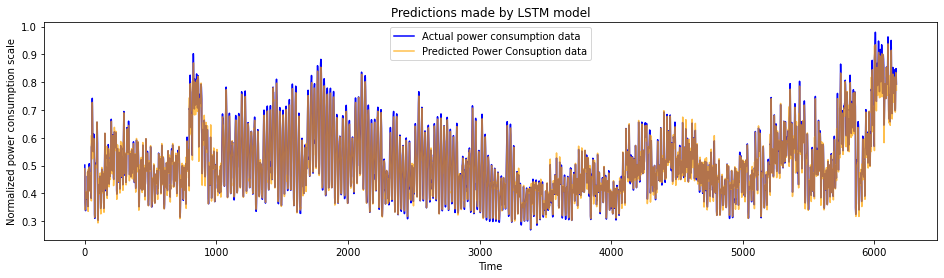

In [65]:
#Same as before, let's use visualization to compare the results

plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

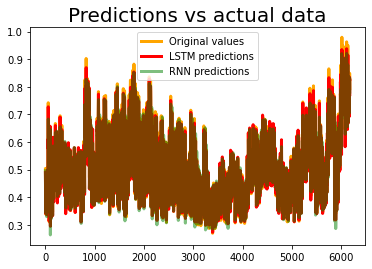

In [66]:
#Finally, let's compare predictions made by SRNN and LSTM by plotting the data

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()